Loading data...
Forecast data: 10906019 rows
Demand data: 196513 rows

Adding lead time based on PERIODID...

Creating standardized keys for merging...

Merging datasets using standardized keys...
Merged data: 10906019 rows
Dataset is very large (10906019 rows). Using a 10% sample for visualization...
Sample size: 1090602 rows

Creating time series visualization...
Sample period has 1884 points. Filtering to get clearer visualization...
Selected lead times for visualization: 0.5h (shortest), 20.0h (medium), 39.0h (longest)


C:\Users\waseem\AppData\Local\Temp\ipykernel_12976\3132785859.py:102: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sample_data['HOUR'] = sample_data['DATETIME_OBJ'].dt.floor('H')
C:\Users\waseem\AppData\Local\Temp\ipykernel_12976\3132785859.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['HOUR'] = sample_data['DATETIME_OBJ'].dt.floor('H')



Creating error distribution visualization...

Creating forecast vs actual scatter plot...

Visualization complete. Images saved.


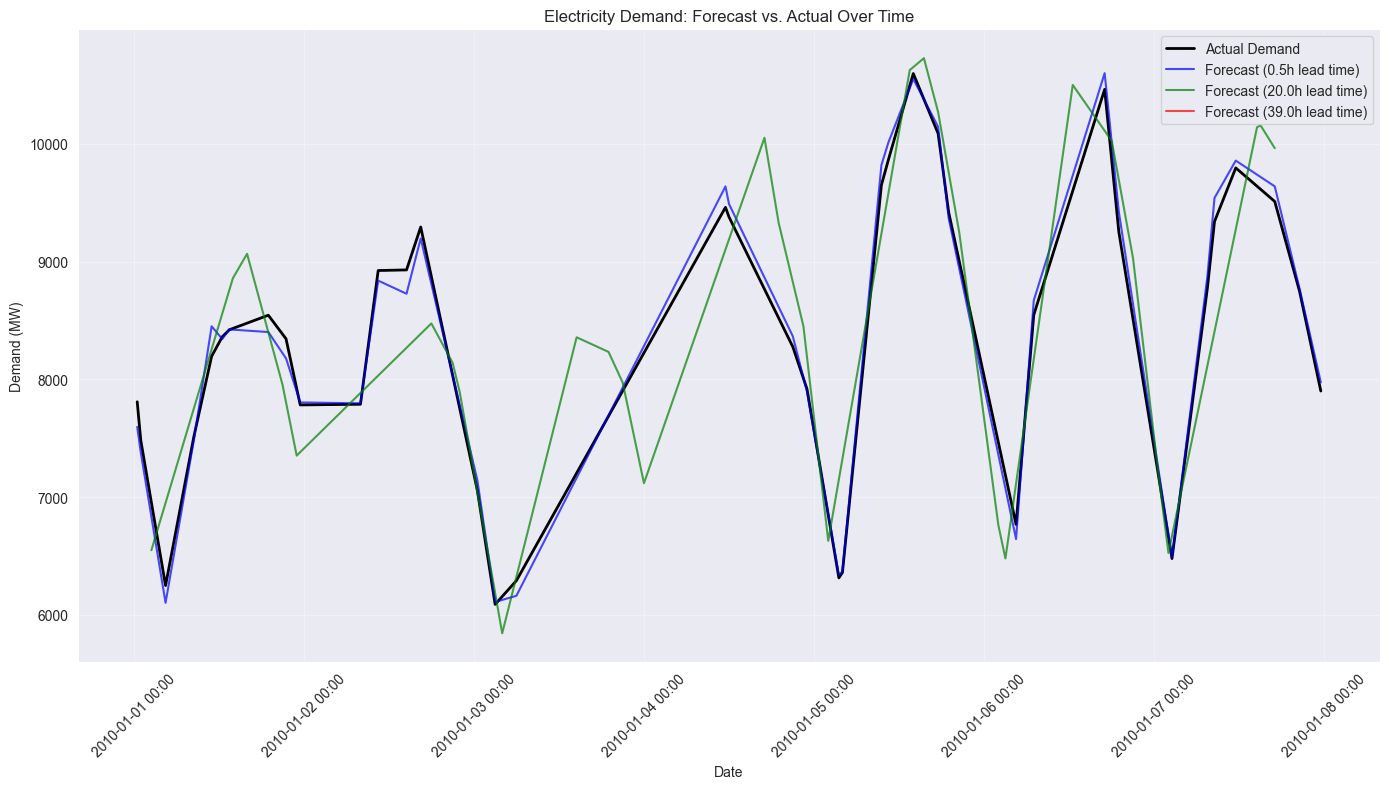

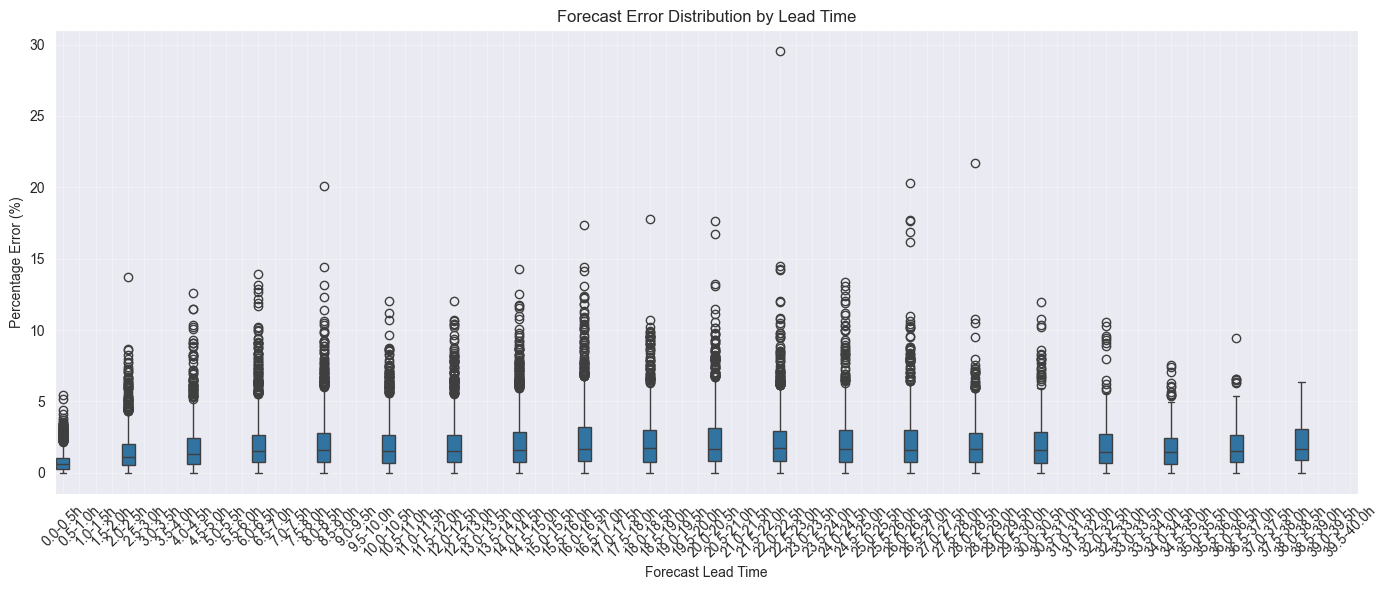

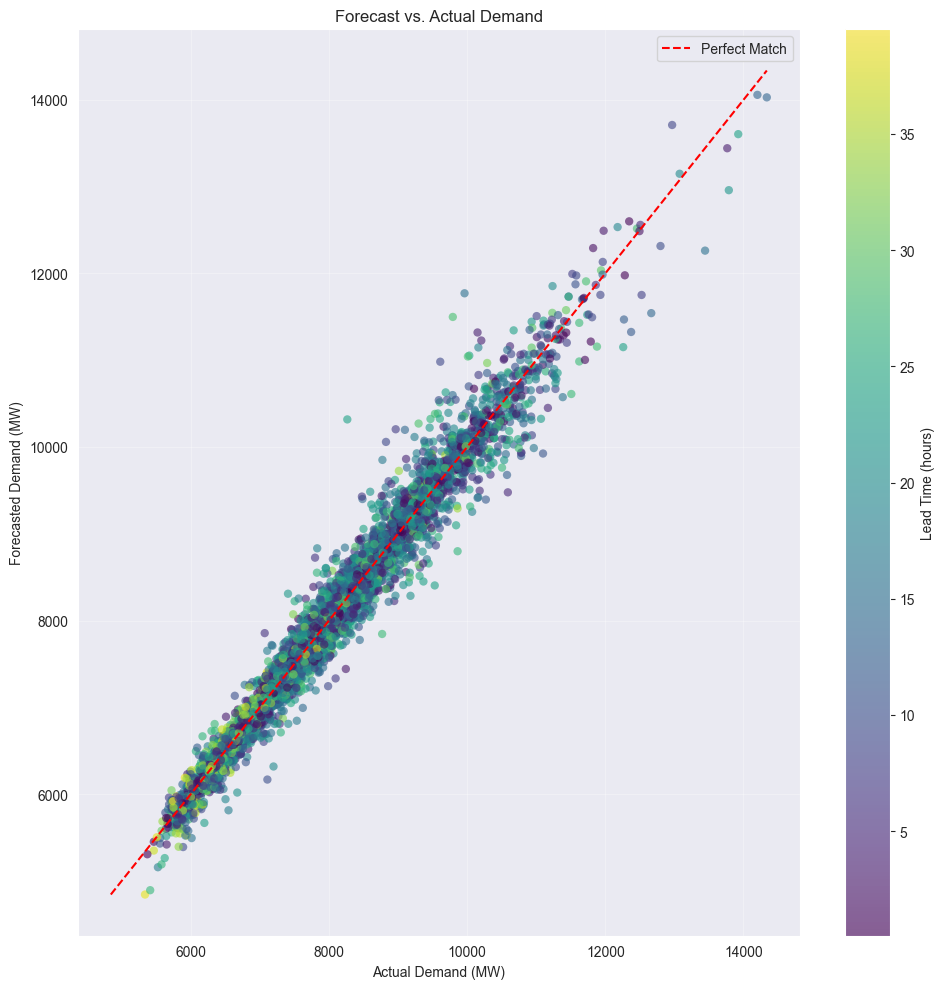

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

# File paths
forecast_path = r"C:\Users\waseem\Desktop\UNSW\Graduation Project\forecastdemand_nsw.csv" # Chnage path
demand_path = r"C:\Users\waseem\Desktop\UNSW\Graduation Project\totaldemand_nsw.csv" #Change Path

# Create lead time mapping from PERIODID
periodid_to_leadtime = {
    71: 35.5, 70: 35, 69: 34.5, 68: 34, 67: 33.5, 66: 33, 65: 32.5, 64: 32,
    63: 31.5, 62: 31, 61: 30.5, 60: 30, 59: 29.5, 58: 29, 57: 28.5, 56: 28,
    55: 27.5, 54: 27, 53: 26.5, 52: 26, 51: 25.5, 50: 25, 49: 24.5, 48: 24,
    47: 23.5, 46: 23, 45: 22.5, 44: 22, 43: 21.5, 42: 21, 41: 20.5, 40: 20,
    39: 19.5, 38: 19, 37: 18.5, 36: 18, 35: 17.5, 34: 17, 33: 16.5, 32: 16,
    31: 15.5, 30: 15, 29: 14.5, 28: 14, 27: 13.5, 26: 13, 25: 12.5, 24: 12,
    23: 11.5, 22: 11, 21: 10.5, 20: 10, 19: 9.5, 18: 9, 17: 8.5, 16: 8,
    15: 7.5, 14: 7, 13: 6.5, 12: 6, 11: 5.5, 10: 5, 9: 4.5, 8: 4, 7: 3.5,
    6: 3, 5: 2.5, 4: 2, 3: 1.5, 2: 1, 1: 0.5, 72: 36, 73: 36.5, 74: 37,
    75: 37.5, 76: 38, 77: 38.5, 78: 39, 79: 39.5
}

# Load data

forecast_df = pd.read_csv(forecast_path)
demand_df = pd.read_csv(demand_path)

print(f"Forecast data: {len(forecast_df)} rows")
print(f"Demand data: {len(demand_df)} rows")

# Add lead time based on PERIODID
print("\nAdding lead time based on PERIODID...")
forecast_df['LEAD_TIME_HOURS'] = forecast_df['PERIODID'].map(periodid_to_leadtime)

# Create standardized keys for merging
print("\nCreating standardized keys for merging...")

def create_matching_key(date_str, is_forecast=True):
    """Create a standardized key from different date formats"""
    try:
        if is_forecast:
            dt = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
        else:
            dt = datetime.strptime(date_str, '%d/%m/%Y %H:%M')
        # Create a standardized key format
        return f"{dt.year}-{dt.month:02d}-{dt.day:02d} {dt.hour:02d}:{dt.minute:02d}"
    except Exception as e:
        return None

# Apply the function to create matching keys
forecast_df['MATCH_KEY'] = forecast_df['DATETIME'].apply(lambda x: create_matching_key(x, True))
demand_df['MATCH_KEY'] = demand_df['DATETIME'].apply(lambda x: create_matching_key(x, False))

# Create datetime objects for visualization
forecast_df['DATETIME_OBJ'] = pd.to_datetime(forecast_df['DATETIME'])
demand_df['DATETIME_OBJ'] = pd.to_datetime(demand_df['DATETIME'], format='%d/%m/%Y %H:%M')

# Merge the datasets using the matching keys
print("\nMerging datasets using standardized keys...")
merged_df = pd.merge(
    forecast_df,
    demand_df[['MATCH_KEY', 'TOTALDEMAND', 'REGIONID', 'DATETIME_OBJ']],
    on=['MATCH_KEY', 'REGIONID'],
    how='inner'
)

print(f"Merged data: {len(merged_df)} rows")

# If the dataset is very large, use a sample for visualization
if len(merged_df) > 1000000:
    print(f"Dataset is very large ({len(merged_df)} rows). Using a 10% sample for visualization...")
    merged_df = merged_df.sample(frac=0.1, random_state=42)
    print(f"Sample size: {len(merged_df)} rows")

# Calculate error metrics
merged_df['ERROR'] = merged_df['FORECASTDEMAND'] - merged_df['TOTALDEMAND']
merged_df['ABS_ERROR'] = abs(merged_df['ERROR'])
merged_df['PERC_ERROR'] = 100 * merged_df['ABS_ERROR'] / merged_df['TOTALDEMAND']

# Use DATETIME_OBJ from the forecast dataframe for consistency
merged_df = merged_df.rename(columns={'DATETIME_OBJ_x': 'DATETIME_OBJ'})

# Sort by datetime for time series visualization
merged_df = merged_df.sort_values('DATETIME_OBJ')

# Visualization 1: Time series of forecast vs actual for a sample period
print("\nCreating time series visualization...")

# Select a sample period
start_date = merged_df['DATETIME_OBJ'].min()
end_date = start_date + timedelta(days=7)  # One week period
sample_data = merged_df[(merged_df['DATETIME_OBJ'] >= start_date) &
                        (merged_df['DATETIME_OBJ'] <= end_date)]

# visualization
if len(sample_data) > 500:
    print(f"Sample period has {len(sample_data)} points. Filtering to get clearer visualization...")
    # Group by hour and lead time for visualization
    sample_data['HOUR'] = sample_data['DATETIME_OBJ'].dt.floor('H')
    grouped = sample_data.groupby(['HOUR', 'LEAD_TIME_HOURS']).agg({
        'FORECASTDEMAND': 'mean',
        'TOTALDEMAND': 'mean',
        'DATETIME_OBJ': 'first'
    }).reset_index()
    sample_data = grouped

# select only a few lead times
lead_times = sorted(sample_data['LEAD_TIME_HOURS'].unique())
if len(lead_times) > 0:
    # Select shortest, medium, and longest lead times
    shortest_lead = lead_times[0]
    medium_lead = lead_times[len(lead_times)//2] if len(lead_times) > 2 else None
    longest_lead = lead_times[-1] if len(lead_times) > 1 else None

    print(f"Selected lead times for visualization: {shortest_lead}h (shortest), "
          f"{medium_lead}h (medium), {longest_lead}h (longest)")

    # Filter data for these lead times
    shortest_lead_data = sample_data[sample_data['LEAD_TIME_HOURS'] == shortest_lead]
    medium_lead_data = sample_data[sample_data['LEAD_TIME_HOURS'] == medium_lead] if medium_lead else None
    longest_lead_data = sample_data[sample_data['LEAD_TIME_HOURS'] == longest_lead] if longest_lead else None

    # Combine actual demand data for a single series
    actual_demand = shortest_lead_data[['DATETIME_OBJ', 'TOTALDEMAND']].copy()
    actual_demand = actual_demand.sort_values('DATETIME_OBJ').drop_duplicates('DATETIME_OBJ')

    # Create visualization
    plt.figure(figsize=(14, 8))

    # Plot actual demand
    plt.plot(actual_demand['DATETIME_OBJ'], actual_demand['TOTALDEMAND'], 'k-',
             label='Actual Demand', linewidth=2)

    # Plot forecasts
    plt.plot(shortest_lead_data['DATETIME_OBJ'], shortest_lead_data['FORECASTDEMAND'], 'b-',
             label=f'Forecast ({shortest_lead}h lead time)', alpha=0.7)

    if medium_lead is not None:
        plt.plot(medium_lead_data['DATETIME_OBJ'], medium_lead_data['FORECASTDEMAND'], 'g-',
                label=f'Forecast ({medium_lead}h lead time)', alpha=0.7)

    if longest_lead is not None:
        plt.plot(longest_lead_data['DATETIME_OBJ'], longest_lead_data['FORECASTDEMAND'], 'r-',
                label=f'Forecast ({longest_lead}h lead time)', alpha=0.7)

    plt.title('Electricity Demand: Forecast vs. Actual Over Time')
    plt.xlabel('Date')
    plt.ylabel('Demand (MW)')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, alpha=0.3)

    # Format x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('forecast_vs_actual_time_series.png')

    # Visualization 2: Error distribution by lead time
    print("\nPLotting error distribution visualization...")
    plt.figure(figsize=(14, 6))

    # Create lead time bins for better visualization
    bins = [i/2 for i in range(81)]  # 0, 0.5, 1, 1.5, ..., 40
    labels = [f'{i/2}-{(i+1)/2}h' for i in range(80)]  # '0-0.5h', '0.5-1h', '1-1.5h', etc.

    merged_df['LEAD_TIME_BIN'] = pd.cut(merged_df['LEAD_TIME_HOURS'], bins=bins, labels=labels)

    # Sample data for visualization because the dataset is very large
    boxplot_data = merged_df
    if len(boxplot_data) > 100000:
        boxplot_data = merged_df.sample(100000, random_state=42)

    # Box plot of percentage error by lead time bin
    # Used a subset of bins for clarity
    selected_bins = [labels[i] for i in range(0, len(labels), 4)]  # Take every 4th bin
    selected_data = boxplot_data[boxplot_data['LEAD_TIME_BIN'].isin(selected_bins)]

    sns.boxplot(x='LEAD_TIME_BIN', y='PERC_ERROR', data=selected_data)
    plt.title('Forecast Error Distribution by Lead Time')
    plt.xlabel('Forecast Lead Time')
    plt.ylabel('Percentage Error (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('forecast_error_distribution.png')

    # Visualization 3: Scatter plot of forecast vs actual
    print("\nCreating forecast vs actual scatter plot...")
    plt.figure(figsize=(10, 10))

    # Select a sample for clearer visualization
    sample_size = min(5000, len(merged_df))
    plot_sample = merged_df.sample(sample_size, random_state=42) if len(merged_df) > sample_size else merged_df

    # Color by lead time
    scatter = plt.scatter(plot_sample['TOTALDEMAND'], plot_sample['FORECASTDEMAND'],
                         c=plot_sample['LEAD_TIME_HOURS'], cmap='viridis',
                         alpha=0.6, edgecolors='none')

    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Lead Time (hours)')

    # Add perfect match line
    max_val = max(plot_sample['TOTALDEMAND'].max(), plot_sample['FORECASTDEMAND'].max())
    min_val = min(plot_sample['TOTALDEMAND'].min(), plot_sample['FORECASTDEMAND'].min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Match')

    plt.title('Forecast vs. Actual Demand')
    plt.xlabel('Actual Demand (MW)')
    plt.ylabel('Forecasted Demand (MW)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('forecast_vs_actual_scatter.png')

    print("\nVisualization complete. Images saved.")
else:
    print("Error: No valid lead times found in the data for visualization.")